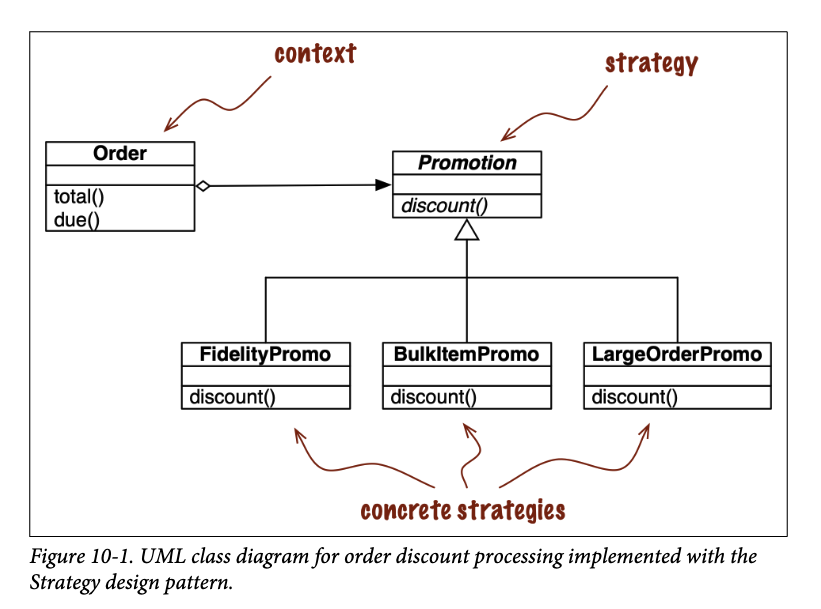

In [15]:
from abc import ABC, abstractmethod
from collections.abc import Sequence
from decimal import Decimal
from typing import NamedTuple, Optional

class Customer(NamedTuple):
    name: str 
    fildelity: int

# print(dir(NamedTuple)) 

class LineItem(NamedTuple):
    product: str 
    quantity: int 
    price: Decimal

    def total(self) -> Decimal:
        return self.price * self.quantity
    
class Order(NamedTuple):
    customer: Customer
    cart: Sequence[LineItem]
    promotion: Optional['Promotion'] = None

    def total(self) -> Decimal:
        totals = (item.total() for item in self.cart)
        return sum(totals, start=Decimal(0))
    
    def due(self) -> Decimal:
        if self.promotion is None:
            discount = Decimal(0)
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        return f'<Order total: {self.total():.2f} due: {self.due():.2f}>'
    
class Promotion(ABC):
    @abstractmethod
    def discount(self, order: Order) -> Decimal:
        """Return discount as a positive dollar amount"""

class FidelityPromo(Promotion):

    def discount(self, order: Order) -> Decimal:
        rate = Decimal('0.05')
        if order.customer.fildelity >= 1_000:
            return order.total() * rate 
        return Decimal(0)
    
class BulkItemPromo(Promotion):

    def discount(self, order: Order) -> Decimal:
        discount = Decimal(0)
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * Decimal('0.1')
        return discount
    
class LargeOrderPromo(Promotion):
    def discount(self, order: Order) -> Decimal:
        # return super().discount(order)
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * Decimal('0.07')
        return Decimal('0')

In [22]:
def fidelity_promo(order: Order) -> Decimal:
    """5% discount for customers with 1000 or more fidelity points"""
    rate = Decimal('0.05')
    if order.customer.fildelity >= 1_000:
        return order.total() * rate 
    return Decimal(0)

def bulk_item_promo(order: Order) -> Decimal:
    """10% discount for each LineItem with 20 or more units"""
    discount = Decimal(0)
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * Decimal('0.1')
    return discount

def large_order_promo(order: Order) -> Decimal:
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * Decimal('0.07')
    return Decimal(0)

In [16]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = (LineItem('banana', 4, Decimal('.5')),
            LineItem('apple', 10, Decimal('1.5')),
            LineItem('watermelon', 5, Decimal(5)))

In [17]:
cart

(LineItem(product='banana', quantity=4, price=Decimal('0.5')),
 LineItem(product='apple', quantity=10, price=Decimal('1.5')),
 LineItem(product='watermelon', quantity=5, price=Decimal('5')))

In [18]:
Order(joe, cart, FidelityPromo())

<Order total: 42.00 due: 42.00>

In [19]:
Order(ann, cart, FidelityPromo())

<Order total: 42.00 due: 39.90>

In [20]:
banana_cart = (LineItem('banana', 30, Decimal('.5')),
               LineItem('apple', 10, Decimal('1.5')))

In [21]:
Order(joe, banana_cart, BulkItemPromo())

<Order total: 30.00 due: 28.50>

In [23]:
promos = [promo for name, promo in globals().items()
          if name.endswith('_promo') and 
          name != 'best_promo']

In [24]:
promos

[<function __main__.fidelity_promo(order: __main__.Order) -> decimal.Decimal>,
 <function __main__.bulk_item_promo(order: __main__.Order) -> decimal.Decimal>,
 <function __main__.large_order_promo(order: __main__.Order) -> decimal.Decimal>]

In [25]:
def best_promo(order: Order) -> Decimal:
    return max(promo(order) for promo in promos)

In [27]:
class MacroCommand:

    def __init__(self, commands):
        self.commands = list(commands)
    
    def __call__(self):
        for command in self.commands:
            command()